# Simulation
### Basic function
To improve the efficiency of calculation, I replace scalars with matrix (or vector); which meaning that there are `nofp` pairs of individuals or corporations trading simultaneously. But to avoid mistakes, we guarantee the agents who consist the `nofp` pairs are unique. 
- `randge(N::Int64, length::Int64)`: generate `nofp` paris index (one $\text{nofp}\times 2$ matrix), and each index is unique. Each row is corresponded to each pair.
- `generate_si_all(N::Int64; length::Int64, lnn::Int64)`
  - `N::Int64`: the total number of agents
  - `length:Int64`: the number of pairs trading simultaneously
  - `lnn::Int64`: the times of iteration, after iteration we could get a relative steady distribution of `m` (the money each agent have)
- `update!(m::Vector{Float64}; lambda::Vector{Float64}, si::Matrix{Float64})`: according to the rule of evolution as following
$$\begin{cases} m_{i}(t+1)  = m_{i}(t)+\Delta m, \\ m_{j}(t+1) = m_{j}(t)- \Delta m, \\ \Delta m = \varepsilon(1-\lambda_{j})m_{j}(t)  - (1-\lambda_{i})(1-\varepsilon)m_{i}(t)\\\varepsilon \sim U(0,1) \end{cases}$$ 
  - we convert the scalar into vector, used two columns of `si` to represent $m_i$ and $m_j$ respectively, and we generate the `EPS` to represent this matrix $\begin{bmatrix}1 - \varepsilon_1 & \varepsilon_1\\\vdots&\vdots\\1-\varepsilon_{\text{nofp}} & \varepsilon_{\text{nofp}}\end{bmatrix}$, `Li` and `Lj` represent these vectors $\begin{bmatrix}-(1-\lambda_{i_{1}})\\\vdots\\-(1-\lambda_{{i_{\text{nofp}}}}) \end{bmatrix}$ and $\begin{bmatrix}1-\lambda_{j_1}\\ \vdots\\ 1-\lambda_{i_{\text{nofp}}}\end{bmatrix}$ respectively. Use `.*` operation, we could get a coefficient matrix $\begin{bmatrix} -(1-\lambda_{i_{1}})(1-\varepsilon_{1}) & \varepsilon_{1}(1-\lambda_{j_{1}}) \\ \vdots & \vdots \\ -(1-\lambda_{i_{1}})(1-\varepsilon_{1}) & \varepsilon_{1}(1-\lambda_{j_{1}}) \\ \end{bmatrix}$, use this coefficient matrix multiply the matrix $\begin{bmatrix}	m_{i_{1}} & m_{i_{2}} & \dots & m_{i_{{\text{nofp}}}}\\	m_{j_{1}} & m_{j_{2}} & \dots & m_{j_{{\text{nofp}}}}\end{bmatrix}$, the diag elements in the result of matrix multiplication is corresponded to the $\Delta m_{i},\, i = 1,2,...,\text{nofp}$

In [2]:
using StatsBase, LinearAlgebra

In [1]:
# generate select index which length is length
## N is the total number of agents, and the length is the number of paris which we want to update in one times
function randge(N::Int64, length::Int64)::Matrix{Int64}
    result::Matrix{Int64} = rand([1:N...], length, 2)
    norepeats(result) && return result
    randge(N, length)
end

randge (generic function with 1 method)

In [3]:
function generate_si_all(N::Int64; length::Int64=nofp, lnn::Int64=lnn)::Array{Matrix{Int64}}
    si_all::Array{Matrix{Int64}} = Array{Matrix{Int64}}(undef, lnn)

    Threads.@threads for i in 1:lnn
        si_all[i] = randge(N, length)
    end
    return si_all
end

generate_si_all (generic function with 1 method)

In [4]:
function update!(m::Vector{Float64}; lambda::Vector{Float64}, si::Matrix{Int64}=si)
    epsilon::Vector{Float64} = rand(size(si)[1])
    EPS::Matrix{Float64} = hcat(1 .- epsilon, epsilon)
    Li::Vector{Float64} = -(1 .- lambda[si[:, 1]])
    Lj::Vector{Float64} = 1 .- lambda[si[:, 2]]
    Deltam::Vector{Float64} = diag(EPS .* hcat(Li, Lj) * hcat(m[si[:, 1]], m[si[:, 2]])')
    m[si[:, 1]] .+= Deltam
    m[si[:, 2]] .-= Deltam
end

update! (generic function with 1 method)

## Initialization

In [5]:
N::Int64 = 200;
nofp::Int64 = 1;
lnn::Int64 = 10^4;
bnn::Int64 = 10^3;

In [6]:
si_all::Array{Matrix{Int64}} = generate_si_all(N; length=nofp, lnn=lnn);
m_diff_lambda = [];

Any[]

## Simulation of homogenous $\lambda$

In [7]:
for k in [0, 0.5, 0.9]
    all_m = Matrix{Float64}(undef, bnn, N)
    Threads.@threads for j in 1:bnn
        m = ones(N)
        lambda = k .* ones(N)
        Threads.@inbounds for i in 1:lnn
            update!(m; lambda=lambda, si=si_all[i])
        end
        all_m[j, :] = m
    end
    push!(m_diff_lambda, all_m)
end

In [8]:
# define the function which convert the vector of m into probability density
function m2pd(m::Vector{Float64}; ps::Vector{Float64})::Matrix{Float64}
    x::Vector{Float64} = (ps[1:end-1] .+ ps[2:end]) ./ 2 # calculate mid points of each small interval
    interval::Vector{Float64} = ps[2:end] .- ps[1:end-1] # calculate the width of each interval
    pdv::Vector{Float64} = [count(i -> ps[j] <= i < ps[j+1], m) for j in 1:(length(ps)-1)] ./ length(m) ./ interval # get the probability density according to the equation (1) above
    return hcat(x, pdv)
end;

In [9]:
# define the function which use the m2pd function and convert the matrix of m into probability density 
function m2pd_all(m::Matrix{Float64}; ps::Vector{Float64})::Matrix{Float64}
    all_pd::Array{Matrix{Float64}} = Array{Matrix}(undef, size(m, 1)) # define a array which is consised of the result of m2pd::Matrix{Float64}, and its length is equal to the times of simulation (the row number of Matrix m)

    # use Threads.@threads to compute m2pd in a multi-threading way.
    Threads.@threads for i in 1:size(m, 1)
        all_pd[i] = m2pd(m[i, :]; ps=ps)# store the i-th simulation probability density result as the i-th elements of all_pd
    end
    avg_pd::Matrix{Float64} = mean(all_pd)# calculate the average probability density
    return avg_pd
end;

In [10]:
using CairoMakie

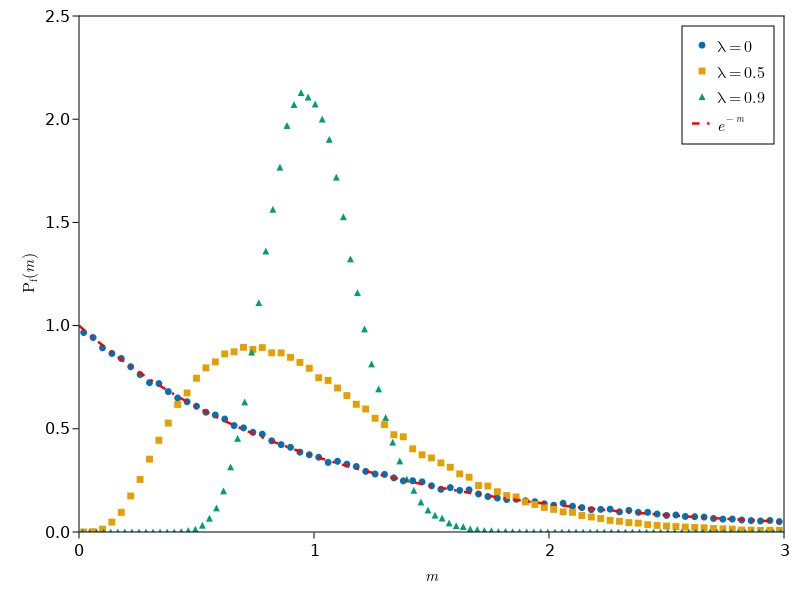

In [11]:
fig = Figure();
ax1 = Axis(
    fig[1, 1],
    xlabel=L"m",
    ylabel=L"\mathrm{P_{f}}(m)"
)
S01 = scatter!(m2pd_all(m_diff_lambda[1], ps=[0:0.04:3...]), marker=:circle)
S02 = scatter!(m2pd_all(m_diff_lambda[2], ps=[0:0.04:3...]), marker=:rect)
S03 = scatter!(m2pd_all(m_diff_lambda[3], ps=[0:0.03:3...]), marker=:utriangle)
l = lines!([0:0.01:3...], exp.(-[0:0.01:3...]), color=:red, linestyle=:dashdot, linewidth=2.5)
xlims!(ax1, 0, 3);
ylims!(ax1, 0, 2.5);
hidedecorations!(ax1, ticks=false, ticklabels=false, label=false)
axislegend(ax1, [S01, S02, S03, l], [L"\lambda=0", L"\lambda=0.5", L"\lambda=0.9", L"e^{-m}"])
fig